<a href="https://colab.research.google.com/github/punchnami/AI-Powered-Research-Query-Chatbot/blob/main/PredictiveModel_LSTM_08052024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Needed Libraries

In [ ]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf
import warnings

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential

#import optuna
#from optuna.integration import TFKerasPruningCallback

# Data Cleaning & Merging

## Search Sheet

In [ ]:
search_file_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/1/Search.xlsx'
df = pd.read_excel(search_file_path)
df_cleaned = df.dropna(axis=1, how='all')
df_cleaned = df_cleaned.drop(columns=['Footnote ID'])
df_cleaned = df_cleaned[df_cleaned['Rate Type'] == 'BGCR']
df_BGCR = df_cleaned.copy()
df_BGCR = df_BGCR.rename(columns={'Effective Date': 'Date'})

## Daily Treasury Rates Sheet

In [ ]:
d_treas_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/2 3. Treasury Yield; Yield Spread; Federal'
files_to_concatenate = [
    'daily-treasury-rates_2018.csv',
    'daily-treasury-rates_2019.csv',
    'daily-treasury-rates_2020.csv',
    'daily-treasury-rates_2021.csv',
    'daily-treasury-rates_2022.csv',
    'daily-treasury-rates_2023.csv',
    'daily-treasury-rates_2024.csv'
]
df_list = []
for file in files_to_concatenate:
    file_path = os.path.join(d_treas_path, file)
    df = pd.read_csv(file_path)
    df_list.append(df)
merged_df = pd.concat(df_list, ignore_index=True)
merged_df = merged_df.dropna(axis=1, how='all')
if 'Footnote ID' in merged_df.columns:
    merged_df = merged_df.drop(columns=['Footnote ID'])
merged_daily_treasury_rates = merged_df.copy()

## Daily Treasury Rates LT Sheet

In [ ]:
files_to_concatenate = [
    'daily-treasury-rates_LT_2018.csv',
    'daily-treasury-rates_LT_2019.csv',
    'daily-treasury-rates_LT_2020.csv',
    'daily-treasury-rates_LT_2021.csv',
    'daily-treasury-rates_LT_2022.csv',
    'daily-treasury-rates_LT_2023.csv',
    'daily-treasury-rates_LT_2024.csv'
]
df_list = []
for file in files_to_concatenate:
    file_path = os.path.join(d_treas_path, file)
    df = pd.read_csv(file_path)
    df_list.append(df)
merged_df = pd.concat(df_list, ignore_index=True)
merged_df = merged_df.dropna(axis=1, how='all')
if 'Footnote ID' in merged_df.columns:
    merged_df = merged_df.drop(columns=['Footnote ID'])
merged_daily_treasury_LT_rates = merged_df.copy()

df_merged = pd.merge(merged_daily_treasury_rates, merged_daily_treasury_LT_rates, on='Date', how='inner')

## Feature Additions

In [ ]:
# Calculate short-term yield spreads
df_merged['Yield Spread (4W - 52W)'] = df_merged['52 WEEKS COUPON EQUIVALENT'] - df_merged['4 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (13W - 52W)'] = df_merged['52 WEEKS COUPON EQUIVALENT'] - df_merged['13 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (26W - 52W)'] = df_merged['52 WEEKS COUPON EQUIVALENT'] - df_merged['26 WEEKS COUPON EQUIVALENT']

# Calculate long-term yield spreads
df_merged['Yield Spread (10Y - 4W)'] = df_merged['LT COMPOSITE (>10 Yrs)'] - df_merged['4 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (20Y - 4W)'] = df_merged['TREASURY 20-Yr CMT'] - df_merged['4 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (10Y - 52W)'] = df_merged['LT COMPOSITE (>10 Yrs)'] - df_merged['52 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (20Y - 52W)'] = df_merged['TREASURY 20-Yr CMT'] - df_merged['52 WEEKS COUPON EQUIVALENT']

## Columns to Keep

In [ ]:
columns_to_keep = [
    'Date',
    '4 WEEKS COUPON EQUIVALENT',
    '13 WEEKS COUPON EQUIVALENT',
    '26 WEEKS COUPON EQUIVALENT',
    '52 WEEKS COUPON EQUIVALENT',
    'LT COMPOSITE (>10 Yrs)',
    'TREASURY 20-Yr CMT',
    'Yield Spread (4W - 52W)',
    'Yield Spread (13W - 52W)',
    'Yield Spread (26W - 52W)',
    'Yield Spread (10Y - 4W)',
    'Yield Spread (20Y - 4W)',
    'Yield Spread (10Y - 52W)',
    'Yield Spread (20Y - 52W)'
]
df_relevant = df_merged[columns_to_keep]

df_merged = pd.merge(df_BGCR, df_relevant, on='Date', how='inner')
df_merged['Date'] = pd.to_datetime(df_merged['Date'])

## Add CPI

In [ ]:
cpi_data = {
    'Year': [2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'Jan': [247.867, 251.712, 257.971, 261.582, 281.148, 299.170, 308.417],
    'Feb': [248.991, 252.776, 258.678, 263.014, 283.716, 300.840, 310.326],
    'Mar': [249.554, 254.202, 258.115, 264.877, 287.504, 301.836, 312.332],
    'Apr': [250.546, 255.548, 256.389, 267.054, 289.109, 303.363, 313.548],
    'May': [251.588, 256.092, 256.934, 269.195, 292.296, 304.127, 314.069],
    'Jun': [251.988, 256.143, 257.797, 271.696, 296.311, 305.109, 314.069],
    'Jul': [252.006, 256.571, 259.101, 273.003, 296.276, 305.691, None],
    'Aug': [252.146, 256.558, 259.918, 273.567, 296.171, 307.026, None],
    'Sep': [252.439, 256.759, 260.280, 274.310, 296.908, 307.789, None],
    'Oct': [252.885, 257.346, 260.388, 276.589, 298.012, 307.671, None],
    'Nov': [252.038, 257.346, 260.229, 277.948, 297.711, 307.051, None],
    'Dec': [251.233, 257.208, 260.474, 278.802, 296.797, 306.746, None]
}


cpi_df = pd.DataFrame(cpi_data)
cpi_long_df = pd.melt(cpi_df, id_vars=['Year'], var_name='Month', value_name='CPI')
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}
cpi_long_df['Month'] = cpi_long_df['Month'].map(month_mapping)
cpi_long_df['Day'] = 1
cpi_long_df['Date'] = pd.to_datetime(cpi_long_df[['Year', 'Month', 'Day']])
cpi_long_df.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)
cpi_long_df.set_index('Date', inplace=True)
cpi_long_df = cpi_long_df.resample('D').ffill()
cpi_long_df.reset_index(inplace=True)
cpi_long_df['Date'] = pd.to_datetime(cpi_long_df['Date'])

df_merged2 = pd.merge(df_merged, cpi_long_df[['Date', 'CPI']], on='Date', how='left')

## Add SPX

In [ ]:
spx_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/6. Stock Market Data/HistoricalData_1719610851813_SPX.csv'
df = pd.read_csv(spx_path)
df = df.drop(columns=['Open', 'High', 'Low'])
df = df.rename(columns={'Close/Last': 'SPX'})
df['Date'] = pd.to_datetime(df['Date'])

df_merged3 = pd.merge(df_merged2, df, on='Date', how='inner')

## Add NASDAQ

In [ ]:
nasdaq_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/6. Stock Market Data/HistoricalData_1719611009685_COMP.csv'
df = pd.read_csv(nasdaq_path)
df = df.drop(columns=['Open', 'High', 'Low'])
df = df.rename(columns={'Close/Last': 'NASDAQ'})
df['Date'] = pd.to_datetime(df['Date'])

df_merged4 = pd.merge(df_merged3, df, on='Date', how='inner')

## Add DJIA

In [ ]:
djia_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/6. Stock Market Data/HistoricalPrices_DJIA.csv'
df = pd.read_csv(djia_path)
df = df.drop(columns=[' Open', ' High', ' Low'], axis=1)
df = df.rename(columns={' Close': 'DJIA'})
df['Date'] = pd.to_datetime(df['Date'])

df_merged5 = pd.merge(df_merged4, df, on='Date', how='inner')

<ipython-input-14-884830d5858d>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


## Add ForEx

In [ ]:
forex_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/7. FX/FRB_H10.csv'
df = pd.read_csv(forex_path)
df = df.iloc[5:]
df.rename(columns={'Series Description': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

df_merged6 = pd.merge(df_merged5, df, on='Date', how='inner')

## Add PPI

In [ ]:
ppi_data = {
    'Year': [2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'Jan': [114.8, 117, 119.3, 121.2, 133.576, 141.286, 142.683],
    'Feb': [115.1, 117.2, 118.6, 122, 134.821, 141.237, 143.509],
    'Mar': [115.3, 117.6, 118, 122.8, 137.041, 140.738, 143.410],
    'Apr': [115.5, 118.2, 116.6, 124.1, 137.805, 140.977, 144.119],
    'May': [115.9, 118.3, 117.2, 125.3, 139.026, 140.664, 144.079],
    'Jun': [116.3, 118.2, 117.5, 126.2, 140.238, 140.672, 144.402],
    'Jul': [116.4, 118.5, 118.2, 127.504, 139.837, 141.461, None],
    'Aug': [116.5, 118.6, 118.4, 128.574, 139.721, 142.353, None],
    'Sep': [116.7, 118.3, 118.7, 129.188, 140.137, 142.658, None],
    'Oct': [117.5, 118.8, 119.4, 130.061, 140.666, 142.191, None],
    'Nov': [117.4, 118.6, 119.5, 131.455, 141.18, 142.267, None],
    'Dec': [117.4, 119, 120, 132.224, 140.696, 142.17, None]
}

# Converting PPI data to DataFrame
ppi_df = pd.DataFrame(ppi_data)

# Melting the PPI DataFrame to long format
ppi_long_df = pd.melt(ppi_df, id_vars=['Year'], var_name='Month', value_name='PPI')

# Mapping month names to numbers
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}
ppi_long_df['Month'] = ppi_long_df['Month'].map(month_mapping)

# Creating a 'Day' column with value 1 for each row
ppi_long_df['Day'] = 1

# Creating a date column in the PPI DataFrame
ppi_long_df['Date'] = pd.to_datetime(ppi_long_df[['Year', 'Month', 'Day']])

# Dropping unnecessary columns
ppi_long_df.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)

# Setting the Date as the index
ppi_long_df.set_index('Date', inplace=True)

# Reindexing to fill in missing dates with forward fill for the last known PPI value of each month
ppi_long_df = ppi_long_df.resample('D').ffill()

# Reset the index to have Date as a column again
ppi_long_df.reset_index(inplace=True)

ppi_long_df['Date'] = pd.to_datetime(ppi_long_df['Date'])
df_merged7 = pd.merge(df_merged6, ppi_long_df[['Date', 'PPI']], on='Date', how='inner')

## Add Unemployment

In [ ]:
unemp_data = {
    'Year': [2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'Jan': [4, 4, 3.6, 6.4, 4, 3.4, 3.7],
    'Feb': [4.1, 3.8, 3.5, 6.2, 3.8, 3.6, 3.9],
    'Mar': [4, 3.8, 4.4, 6.1, 3.6, 3.5, 3.8],
    'Apr': [4, 3.7, 14.8, 6.1, 3.7, 3.4, 3.9],
    'May': [3.8, 3.6, 13.2, 5.8, 3.6, 3.7, 4],
    'Jun': [4, 3.6, 11, 5.9, 3.6, 3.6, 4.1],
    'Jul': [3.8, 3.7, 10.2, 5.4, 3.5, 3.5, None],
    'Aug': [3.8, 3.6, 8.4, 5.1, 3.6, 3.8, None],
    'Sep': [3.7, 3.5, 7.8, 4.7, 3.5, 3.8, None],
    'Oct': [3.8, 3.6, 6.8, 4.5, 3.6, 3.8, None],
    'Nov': [3.8, 3.6, 6.7, 4.1, 3.6, 3.7, None],
    'Dec': [3.9, 3.6, 6.7, 3.9, 3.5, 3.7, None]
}

# Converting Unempl data to DataFrame
unemp_df = pd.DataFrame(unemp_data)

# Melting the Unempl DataFrame to long format
unemp_long_df = pd.melt(unemp_df, id_vars=['Year'], var_name='Month', value_name='Unemployment')

# Maunempng month names to numbers
month_maunempng = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}
unemp_long_df['Month'] = unemp_long_df['Month'].map(month_maunempng)

# Creating a 'Day' column with value 1 for each row
unemp_long_df['Day'] = 1

# Creating a date column in the Unempl DataFrame
unemp_long_df['Date'] = pd.to_datetime(unemp_long_df[['Year', 'Month', 'Day']])

# Drounempng unnecessary columns
unemp_long_df.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)

# Setting the Date as the index
unemp_long_df.set_index('Date', inplace=True)

# Reindexing to fill in missing dates with forward fill for the last known Unempl value of each month
unemp_long_df = unemp_long_df.resample('D').ffill()

# Reset the index to have Date as a column again
unemp_long_df.reset_index(inplace=True)

unemp_long_df['Date'] = pd.to_datetime(unemp_long_df['Date'])
df_merged8 = pd.merge(df_merged7, unemp_long_df[['Date', 'Unemployment']], on='Date', how='inner')

## Final Feature Set

In [ ]:
df_final = df_merged8.copy()
df_final = df_final.drop(columns=[ 'Rate Type','1st Percentile (%)', '25th Percentile (%)', '75th Percentile (%)', '99th Percentile (%)',
                                  '4 WEEKS COUPON EQUIVALENT', '13 WEEKS COUPON EQUIVALENT', '26 WEEKS COUPON EQUIVALENT', '52 WEEKS COUPON EQUIVALENT'])

# Set the 'Date' column as the index
df_final.set_index('Date', inplace=True)
df_final2 = df_final.sort_index(ascending=True)
df_final2

# Replace 'ND' with NaN and fill with a method or drop rows
df_final2.replace('ND', np.nan, inplace=True)

print("NaN values in original features dataframe before dropping:")
print(df_final2.isna().sum())

# Drop rows with NaN values in the dataframe
df_final2.dropna(inplace=True)

cols = ['SPOT EXCHANGE RATE - EURO AREA ', 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)', 'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ', 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ']
df_final2[cols] = df_final2[cols].astype(float)

# Re-check for any remaining NaN values
print("\n\nNaN values in original features dataframe after dropping:")
print(df_final2.isna().sum())

NaN values in original features dataframe before dropping:
Rate (%)                                                          0
Volume ($Billions)                                                0
LT COMPOSITE (>10 Yrs)                                            0
TREASURY 20-Yr CMT                                                0
Yield Spread (4W - 52W)                                           0
Yield Spread (13W - 52W)                                          0
Yield Spread (26W - 52W)                                          0
Yield Spread (10Y - 4W)                                           0
Yield Spread (20Y - 4W)                                           0
Yield Spread (10Y - 52W)                                          0
Yield Spread (20Y - 52W)                                          0
CPI                                                               0
SPX                                                               0
NASDAQ                                                   

# Training Model

In [ ]:
# Split into train and test

train = df_final2[:'2022-12-31']
test = df_final2['2023-01-01':]

In [ ]:
# Split into X & y

y_train = train['Rate (%)']
X_train = train.drop(columns=['Rate (%)'])
y_test = test['Rate (%)']
X_test = test.drop(columns=['Rate (%)'])

In [ ]:
# Scaling values

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Model definition

def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(target[i+seq_length])
    return np.array(X), np.array(y)

# Define the sequence length
seq_length = 30

# Create sequences
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, seq_length)

# Check the shapes of the sequences
print(X_train_seq.shape, y_train_seq.shape)
print(X_test_seq.shape, y_test_seq.shape)

(1151, 30, 20) (1151,)
(337, 30, 20) (337,)


# Prediction

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 1.1392 - val_loss: 2.6158
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0817 - val_loss: 1.0412
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0593 - val_loss: 0.9570
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0644 - val_loss: 0.8402
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0628 - val_loss: 0.7874
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0423 - val_loss: 0.6739
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0497 - val_loss: 0.6311
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0518 - val_loss: 0.4181
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0386 - val_loss: 0.6085
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0373 - val_loss: 0.8804
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0714 - val_loss: 0.5925
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0

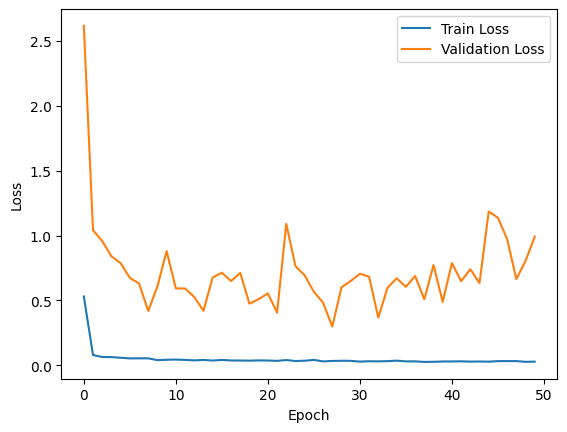

In [ ]:
# Build the baseline LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, X_train_seq.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_seq, y_train_seq, batch_size=32, epochs=50, validation_data=(X_test_seq, y_test_seq))

# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 2.7752 - val_loss: 4.2684
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.2718 - val_loss: 2.4654
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.9851 - val_loss: 1.9434
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.7995 - val_loss: 2.0320
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.6529 - val_loss: 1.3435
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.5725 - val_loss: 1.3955
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.4886 - val_loss: 1.5921
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.4450 - val_loss: 1.2722
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.4022 - val_loss: 1.0581
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.3263 - val_loss: 0.9877
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.3061 - val_loss: 0.7619
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.2

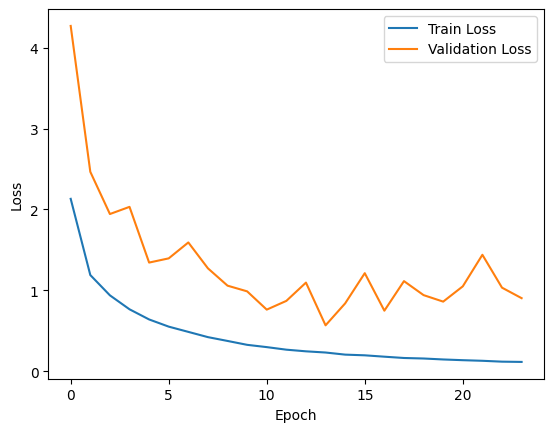

In [ ]:
# Add Early Stopping & Regularization

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, X_train_seq.shape[2]), kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(25, kernel_regularizer=l2(0.01)))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_seq, y_train_seq, batch_size=32, epochs=50, validation_data=(X_test_seq, y_test_seq), callbacks=[early_stopping])

# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Optuna Hyperparamter Tuning

def objective(trial):
    # Hyperparameters to tune
    n_lstm_units = trial.suggest_int('n_lstm_units', 50, 200)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    l2_regularization = trial.suggest_float('l2_regularization', 1e-4, 1e-2)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    batch_size = trial.suggest_int('batch_size', 16, 64)

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(n_lstm_units, return_sequences=True, input_shape=(seq_length, X_train_seq.shape[2]), kernel_regularizer=l2(l2_regularization)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(n_lstm_units, return_sequences=False, kernel_regularizer=l2(l2_regularization)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(25, kernel_regularizer=l2(l2_regularization)))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model with early stopping
    history = model.fit(X_train_seq, y_train_seq, batch_size=batch_size, epochs=50, validation_data=(X_test_seq, y_test_seq), callbacks=[early_stopping, TFKerasPruningCallback(trial, 'val_loss')])

    # Evaluate the model
    val_loss = model.evaluate(X_test_seq, y_test_seq, verbose=0)
    return val_loss

# Create the study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print('Best hyperparameters: ', study.best_params)

# Plot optimization history
optuna.visualization.plot_optimization_history(study)

[I 2024-08-04 21:00:42,476] A new study created in memory with name: no-name-c721c865-f60f-40f0-ba2d-fcd190176db7
<ipython-input-34-27abe461dc54>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 433ms/step - loss: 2.5642 - val_loss: 2.6212
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - loss: 1.2142 - val_loss: 1.0497
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - loss: 0.9888 - val_loss: 0.9796
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 239ms/step - loss: 0.8287 - val_loss: 0.9235
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - loss: 0.7143 - val_loss: 0.9083
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - loss: 0.6327 - val_loss: 0.8066
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 277ms/step - loss: 0.5454 - val_loss: 0.6293
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - loss: 0.4913 - val_loss: 0.9687
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 283ms/step - loss: 0.4542 - val_loss: 0.5939
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - loss: 0.4111 - val_loss: 0.5553
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 273ms/step - loss: 0.3929 - val_loss: 0.4578
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/ste

[I 2024-08-04 21:04:39,883] Trial 0 finished with value: 0.29215481877326965 and parameters: {'n_lstm_units': 184, 'dropout_rate': 0.3290262355472924, 'l2_regularization': 0.003552748136893835, 'learning_rate': 0.0005847668310241149, 'batch_size': 61}. Best is trial 0 with value: 0.29215481877326965.


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - loss: 5.2438 - val_loss: 1.9783
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - loss: 1.6522 - val_loss: 2.4515
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 1.1832 - val_loss: 1.7570
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.8798 - val_loss: 1.1284
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.6951 - val_loss: 0.8854
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - loss: 0.5852 - val_loss: 1.4793
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.4610 - val_loss: 2.7650
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.3963 - val_loss: 1.2532
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.3267 - val_loss: 1.9911
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.2966 - val_loss: 0.7307
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - loss: 0.2482 - val_loss: 3.5800
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step

[I 2024-08-04 21:05:47,056] Trial 1 finished with value: 0.7306978106498718 and parameters: {'n_lstm_units': 126, 'dropout_rate': 0.45505431755055986, 'l2_regularization': 0.005934695591589058, 'learning_rate': 0.008448694618680756, 'batch_size': 55}. Best is trial 0 with value: 0.29215481877326965.


Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - loss: 1.9108 - val_loss: 2.9785
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - loss: 0.5065 - val_loss: 1.2575
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - loss: 0.2886 - val_loss: 1.4594
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - loss: 0.2209 - val_loss: 1.8531
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - loss: 0.2115 - val_loss: 0.8797
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 0.1508 - val_loss: 1.5442
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - loss: 0.1292 - val_loss: 1.8797
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - loss: 0.1042 - val_loss: 1.0658
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - loss: 0.1178 - val_loss: 1.2905
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - loss: 0.0855 - val_loss: 1.2685
Epoch 11/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - loss: 0.0702 - val_loss: 1.5196
Epoch 12/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/ste

[I 2024-08-04 21:10:42,250] Trial 2 finished with value: 0.3321649134159088 and parameters: {'n_lstm_units': 177, 'dropout_rate': 0.31450746823126274, 'l2_regularization': 0.003388295227466571, 'learning_rate': 0.004155933132277229, 'batch_size': 21}. Best is trial 0 with value: 0.29215481877326965.


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - loss: 2.8092 - val_loss: 2.0049
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - loss: 1.5278 - val_loss: 1.2800
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - loss: 1.2574 - val_loss: 1.0898
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step - loss: 1.0571 - val_loss: 0.8968
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - loss: 0.9057 - val_loss: 0.7764
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - loss: 0.7805 - val_loss: 0.6733
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - loss: 0.6784 - val_loss: 0.5981
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - loss: 0.6089 - val_loss: 0.5459
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - loss: 0.5454 - val_loss: 0.4953
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 199ms/step - loss: 0.5031 - val_loss: 0.4840
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - loss: 0.4687 - val_loss: 0.4709
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/ste

[I 2024-08-04 21:14:37,436] Trial 3 finished with value: 0.20622816681861877 and parameters: {'n_lstm_units': 186, 'dropout_rate': 0.29066044549780823, 'l2_regularization': 0.004756508042933838, 'learning_rate': 0.0003575563041814042, 'batch_size': 37}. Best is trial 3 with value: 0.20622816681861877.


Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - loss: 2.4997 - val_loss: 2.5666
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 1.0035 - val_loss: 1.4077
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.7147 - val_loss: 1.2479
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.5735 - val_loss: 0.8218
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - loss: 0.4698 - val_loss: 0.7150
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.4299 - val_loss: 0.5262
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 0.3435 - val_loss: 0.9828
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - loss: 0.3203 - val_loss: 0.9937
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.2902 - val_loss: 0.6134
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 0.2492 - val_loss: 0.3337
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - loss: 0.2171 - val_loss: 0.7151
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - loss

[I 2024-08-04 21:16:14,736] Trial 4 finished with value: 0.3337240517139435 and parameters: {'n_lstm_units': 113, 'dropout_rate': 0.21445890130843215, 'l2_regularization': 0.005533872324708605, 'learning_rate': 0.0010569554455118584, 'batch_size': 35}. Best is trial 3 with value: 0.20622816681861877.


Epoch 1/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 3.4841

[I 2024-08-04 21:16:20,433] Trial 5 pruned. Trial was pruned at epoch 0.


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - loss: 1.4795 - val_loss: 0.9985
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - loss: 0.5154 - val_loss: 0.6867
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - loss: 0.3578 - val_loss: 0.5391
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - loss: 0.2922 - val_loss: 0.2494
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - loss: 0.2859 - val_loss: 0.2389
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - loss: 0.2261 - val_loss: 0.2827
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step - loss: 0.2208 - val_loss: 0.8967
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - loss: 0.1720 - val_loss: 0.3021
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step - loss: 0.1561 - val_loss: 0.2559
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - loss: 0.1894 - val_loss: 0.2704
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 196ms/step - loss: 0.1355 - val_loss: 0.7884
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/st

[I 2024-08-04 21:18:18,730] Trial 6 finished with value: 0.2389240711927414 and parameters: {'n_lstm_units': 177, 'dropout_rate': 0.23603295259004822, 'l2_regularization': 0.002242726768425981, 'learning_rate': 0.0015565612726871664, 'batch_size': 37}. Best is trial 3 with value: 0.20622816681861877.


Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 4.0200

[I 2024-08-04 21:18:30,231] Trial 7 pruned. Trial was pruned at epoch 0.


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step - loss: 0.9687 - val_loss: 0.4607
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - loss: 0.2590 - val_loss: 0.4329
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - loss: 0.2371 - val_loss: 0.1565
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 0.1634 - val_loss: 0.3806
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - loss: 0.1289 - val_loss: 0.4825
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - loss: 0.1397 - val_loss: 1.1999
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - loss: 0.1172 - val_loss: 0.7469
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 12s 159ms/step - loss: 0.0967 - val_loss: 0.4143
Epoch 9/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - loss: 0.0956 - val_loss: 1.5861
Epoch 10/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - loss: 0.0983 - val_loss: 0.6489
Epoch 11/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - loss: 0.0777 - val_loss: 0.2363
Epoch 12/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 139m

[I 2024-08-04 21:20:36,338] Trial 8 finished with value: 0.15651988983154297 and parameters: {'n_lstm_units': 198, 'dropout_rate': 0.31627238782044387, 'l2_regularization': 0.0006273834619981126, 'learning_rate': 0.001938665097567327, 'batch_size': 23}. Best is trial 8 with value: 0.15651988983154297.


Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 3.3056

[I 2024-08-04 21:20:47,182] Trial 9 pruned. Trial was pruned at epoch 0.


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 1.2918

[I 2024-08-04 21:20:54,052] Trial 10 pruned. Trial was pruned at epoch 0.


Epoch 1/50
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 4.5519

[I 2024-08-04 21:21:03,273] Trial 11 pruned. Trial was pruned at epoch 0.


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step - loss: 1.0877 - val_loss: 0.4885
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - loss: 0.1843 - val_loss: 0.1930
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - loss: 0.1825 - val_loss: 0.1743
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 0.1716 - val_loss: 0.1864
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - loss: 0.1474 - val_loss: 0.1321
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - loss: 0.1429 - val_loss: 0.1256
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 0.1486 - val_loss: 0.1041
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - loss: 0.1328 - val_loss: 0.1177
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - loss: 0.1544 - val_loss: 0.1107
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - loss: 0.1195 - val_loss: 0.3319
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 0.1316 - val_loss: 0.0966
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 201ms/ste

[I 2024-08-04 21:23:45,819] Trial 12 finished with value: 0.07456349581480026 and parameters: {'n_lstm_units': 150, 'dropout_rate': 0.368548867678468, 'l2_regularization': 0.0003679305584399327, 'learning_rate': 0.0005197982374078899, 'batch_size': 44}. Best is trial 12 with value: 0.07456349581480026.


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 204ms/step - loss: 1.1639 - val_loss: 1.7732
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - loss: 0.3218 - val_loss: 0.2930
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step - loss: 0.1328 - val_loss: 0.4153
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - loss: 0.1111 - val_loss: 0.3287
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - loss: 0.0966 - val_loss: 0.0945
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - loss: 0.0970 - val_loss: 0.1606
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - loss: 0.1014 - val_loss: 0.0879
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 0.0709 - val_loss: 0.0512
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - loss: 0.0992 - val_loss: 0.2343
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - loss: 0.0675 - val_loss: 0.0570
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 0.0780 - val_loss: 0.1061
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/ste

[I 2024-08-04 21:26:04,598] Trial 13 finished with value: 0.04754108935594559 and parameters: {'n_lstm_units': 146, 'dropout_rate': 0.3745429000629645, 'l2_regularization': 0.00010999348147006397, 'learning_rate': 0.000683199718996704, 'batch_size': 46}. Best is trial 13 with value: 0.04754108935594559.


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 1.8349

[I 2024-08-04 21:26:11,994] Trial 14 pruned. Trial was pruned at epoch 0.


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - loss: 1.1006 - val_loss: 0.1337
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - loss: 0.2003 - val_loss: 0.1692
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 0.1535 - val_loss: 0.5153
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step - loss: 0.1408 - val_loss: 0.3325
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - loss: 0.1311 - val_loss: 0.2322
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - loss: 0.1248 - val_loss: 0.0803
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - loss: 0.1303 - val_loss: 0.2138
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - loss: 0.1119 - val_loss: 0.1564
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - loss: 0.1016 - val_loss: 0.2218
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - loss: 0.1070 - val_loss: 0.4320
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - loss: 0.0946 - val_loss: 0.0782
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step

[I 2024-08-04 21:28:25,491] Trial 15 finished with value: 0.0737338587641716 and parameters: {'n_lstm_units': 148, 'dropout_rate': 0.43438988758075314, 'l2_regularization': 0.0002423506548843548, 'learning_rate': 0.000643585705011195, 'batch_size': 45}. Best is trial 13 with value: 0.04754108935594559.


Epoch 1/50
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 1.7954

[I 2024-08-04 21:28:39,710] Trial 16 pruned. Trial was pruned at epoch 0.


Epoch 1/50
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 1.9462

[I 2024-08-04 21:28:47,977] Trial 17 pruned. Trial was pruned at epoch 0.


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - loss: 1.8530 - val_loss: 0.6396
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - loss: 0.6835 - val_loss: 1.3638
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - loss: 0.5830 - val_loss: 0.9162
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.4380 - val_loss: 0.4762
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.3908 - val_loss: 0.3418
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - loss: 0.3454 - val_loss: 0.7066
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.3158 - val_loss: 0.3557
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 0.2844 - val_loss: 0.6717
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - loss: 0.2597 - val_loss: 0.3293
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.2454 - val_loss: 0.2934
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - loss: 0.2440 - val_loss: 0.4042
Epoch 12/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 203ms/ste

[I 2024-08-04 21:31:12,170] Trial 18 pruned. Trial was pruned at epoch 23.


Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - loss: 1.7320 - val_loss: 0.9598
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 0.5103 - val_loss: 0.4982
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - loss: 0.4557 - val_loss: 0.3932
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - loss: 0.3959 - val_loss: 0.3116
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - loss: 0.3888 - val_loss: 0.5515
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - loss: 0.3416 - val_loss: 0.4170
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - loss: 0.2980 - val_loss: 0.6234
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - loss: 0.3020 - val_loss: 0.5760
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - loss: 0.2886 - val_loss: 0.2955
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - loss: 0.2453 - val_loss: 0.2670
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - loss: 0.2304 - val_loss: 0.2236
Epoch 12/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - l

[I 2024-08-04 21:35:32,046] Trial 19 finished with value: 0.15085652470588684 and parameters: {'n_lstm_units': 159, 'dropout_rate': 0.42139930345162696, 'l2_regularization': 0.001354818352110142, 'learning_rate': 0.00018931863384553574, 'batch_size': 16}. Best is trial 13 with value: 0.04754108935594559.


Epoch 1/50
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 2.6603

[I 2024-08-04 21:35:39,931] Trial 20 pruned. Trial was pruned at epoch 0.


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - loss: 1.4228 - val_loss: 1.0607
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - loss: 0.4194 - val_loss: 0.3437
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - loss: 0.3632 - val_loss: 0.3825
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - loss: 0.3248 - val_loss: 0.2945
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - loss: 0.2804 - val_loss: 0.2539
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - loss: 0.2717 - val_loss: 0.2186
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - loss: 0.2425 - val_loss: 0.2823
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 0.2364 - val_loss: 0.2720
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - loss: 0.2088 - val_loss: 0.3634
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - loss: 0.1996 - val_loss: 0.1810
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - loss: 0.1963 - val_loss: 0.3170
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step

[I 2024-08-04 21:39:01,504] Trial 21 finished with value: 0.10980746150016785 and parameters: {'n_lstm_units': 155, 'dropout_rate': 0.364955156015125, 'l2_regularization': 0.0011325612988087857, 'learning_rate': 0.000564640799455025, 'batch_size': 44}. Best is trial 13 with value: 0.04754108935594559.


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - loss: 1.5706 - val_loss: 0.6723
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.2881 - val_loss: 0.2072
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step - loss: 0.2049 - val_loss: 0.5602
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 0.1695 - val_loss: 0.2187
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - loss: 0.1716 - val_loss: 0.5454
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - loss: 0.2467 - val_loss: 0.2950
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - loss: 0.1521 - val_loss: 0.1317
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 0.1582 - val_loss: 0.1092
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - loss: 0.1426 - val_loss: 0.2433
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - loss: 0.1363 - val_loss: 0.1071
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - loss: 0.1284 - val_loss: 0.1492
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/ste

[I 2024-08-04 21:41:49,914] Trial 22 finished with value: 0.07284346222877502 and parameters: {'n_lstm_units': 137, 'dropout_rate': 0.4058757768840666, 'l2_regularization': 0.00031266289295162004, 'learning_rate': 0.00037284584283654357, 'batch_size': 50}. Best is trial 13 with value: 0.04754108935594559.


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 2.0155

[I 2024-08-04 21:41:57,132] Trial 23 pruned. Trial was pruned at epoch 0.


Epoch 1/50
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 1.4610

[I 2024-08-04 21:42:06,447] Trial 24 pruned. Trial was pruned at epoch 0.


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 1.3247

[I 2024-08-04 21:42:17,356] Trial 25 pruned. Trial was pruned at epoch 0.


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 2.4092

[I 2024-08-04 21:42:24,829] Trial 26 pruned. Trial was pruned at epoch 0.


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 2.5540

[I 2024-08-04 21:42:33,065] Trial 27 pruned. Trial was pruned at epoch 0.


Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 2.1685

[I 2024-08-04 21:42:42,320] Trial 28 pruned. Trial was pruned at epoch 0.


Epoch 1/50
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 4.2805

[I 2024-08-04 21:42:54,158] Trial 29 pruned. Trial was pruned at epoch 0.


Epoch 1/50
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 2.3908

[I 2024-08-04 21:43:05,512] Trial 30 pruned. Trial was pruned at epoch 0.


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 1.1848

[I 2024-08-04 21:43:16,198] Trial 31 pruned. Trial was pruned at epoch 0.


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 1.8658

[I 2024-08-04 21:43:26,613] Trial 32 pruned. Trial was pruned at epoch 0.


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - loss: 1.3795 - val_loss: 0.5499
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 233ms/step - loss: 0.5064 - val_loss: 0.4910
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - loss: 0.3936 - val_loss: 0.3108
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - loss: 0.3224 - val_loss: 0.3769
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - loss: 0.2820 - val_loss: 0.4176
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - loss: 0.2725 - val_loss: 0.2241
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - loss: 0.2470 - val_loss: 0.2511
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - loss: 0.2293 - val_loss: 0.1872
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - loss: 0.2043 - val_loss: 0.2031
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - loss: 0.2242 - val_loss: 0.1549
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - loss: 0.1763 - val_loss: 0.3200
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step

[I 2024-08-04 21:45:33,347] Trial 33 finished with value: 0.13975952565670013 and parameters: {'n_lstm_units': 175, 'dropout_rate': 0.46296618882620877, 'l2_regularization': 0.0013938768354251037, 'learning_rate': 0.0012218958627455664, 'batch_size': 47}. Best is trial 13 with value: 0.04754108935594559.


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 175ms/step - loss: 1.4532 - val_loss: 0.8490
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 0.1730 - val_loss: 0.2396
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - loss: 0.1491 - val_loss: 0.1483
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - loss: 0.1346 - val_loss: 0.0741
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - loss: 0.1152 - val_loss: 0.0815
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - loss: 0.1125 - val_loss: 0.0666
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 205ms/step - loss: 0.1311 - val_loss: 0.0657
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - loss: 0.1188 - val_loss: 0.0978
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - loss: 0.1018 - val_loss: 0.0722
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - loss: 0.1138 - val_loss: 0.0719
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - loss: 0.1032 - val_loss: 0.0806
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 203ms/ste

[I 2024-08-04 21:49:48,523] Trial 34 finished with value: 0.05713937059044838 and parameters: {'n_lstm_units': 151, 'dropout_rate': 0.39944449602418025, 'l2_regularization': 0.00018234365336580863, 'learning_rate': 0.00026194262894006423, 'batch_size': 39}. Best is trial 13 with value: 0.04754108935594559.


Epoch 1/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 2.1088

[I 2024-08-04 21:49:58,473] Trial 35 pruned. Trial was pruned at epoch 0.


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 2.0377

[I 2024-08-04 21:50:05,251] Trial 36 pruned. Trial was pruned at epoch 0.


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 1.7400

[I 2024-08-04 21:50:14,162] Trial 37 pruned. Trial was pruned at epoch 0.


Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 4.0306

[I 2024-08-04 21:50:24,316] Trial 38 pruned. Trial was pruned at epoch 0.


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - loss: 1.6377 - val_loss: 0.5443
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.4908

[I 2024-08-04 21:50:38,237] Trial 39 pruned. Trial was pruned at epoch 1.


Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 5.4470

[I 2024-08-04 21:50:49,174] Trial 40 pruned. Trial was pruned at epoch 0.


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 1.2286

[I 2024-08-04 21:50:57,978] Trial 41 pruned. Trial was pruned at epoch 0.


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 224ms/step - loss: 1.3895 - val_loss: 0.9407
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - loss: 0.3242 - val_loss: 0.1800
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - loss: 0.2518 - val_loss: 0.1705
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - loss: 0.2197 - val_loss: 0.1700
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - loss: 0.2143 - val_loss: 0.1570
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - loss: 0.1976 - val_loss: 0.1767
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 181ms/step - loss: 0.1986 - val_loss: 0.1418
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - loss: 0.1815 - val_loss: 0.1379
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - loss: 0.1796 - val_loss: 0.1362
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - loss: 0.1742 - val_loss: 0.2846
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 204ms/step - loss: 0.1748 - val_loss: 0.1458
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step

[I 2024-08-04 21:54:17,633] Trial 42 pruned. Trial was pruned at epoch 39.


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 3.6892

[I 2024-08-04 21:54:26,340] Trial 43 pruned. Trial was pruned at epoch 0.


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.3418

[I 2024-08-04 21:54:37,443] Trial 44 pruned. Trial was pruned at epoch 0.


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 1.5198

[I 2024-08-04 21:54:47,962] Trial 45 pruned. Trial was pruned at epoch 0.


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 1.2271

[I 2024-08-04 21:54:56,279] Trial 46 pruned. Trial was pruned at epoch 0.


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 216ms/step - loss: 1.1631 - val_loss: 0.4994
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 0.2682 - val_loss: 0.4354
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.2158 - val_loss: 0.3534
Epoch 4/50
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.2057

[I 2024-08-04 21:55:12,589] Trial 47 pruned. Trial was pruned at epoch 3.


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - loss: 1.1945 - val_loss: 0.5089
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - loss: 0.3960 - val_loss: 0.2922
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - loss: 0.3302 - val_loss: 0.2799
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - loss: 0.2665 - val_loss: 0.2173
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - loss: 0.2352 - val_loss: 0.2051
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - loss: 0.2086 - val_loss: 0.1752
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - loss: 0.1922 - val_loss: 0.3397
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - loss: 0.1750 - val_loss: 0.1827
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step - loss: 0.1781 - val_loss: 0.1453
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - loss: 0.1742 - val_loss: 0.1643
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - loss: 0.1475 - val_loss: 0.2014
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/ste

[I 2024-08-04 21:58:01,317] Trial 48 finished with value: 0.09346329420804977 and parameters: {'n_lstm_units': 192, 'dropout_rate': 0.29916589934438365, 'l2_regularization': 0.001031072135557323, 'learning_rate': 0.0010917278274564575, 'batch_size': 48}. Best is trial 13 with value: 0.04754108935594559.


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 1.0250

[I 2024-08-04 21:58:10,658] Trial 49 pruned. Trial was pruned at epoch 0.


Best hyperparameters:  {'n_lstm_units': 146, 'dropout_rate': 0.3745429000629645, 'l2_regularization': 0.00010999348147006397, 'learning_rate': 0.000683199718996704, 'batch_size': 46}


In [ ]:
# Retrieve the best trial
best_trial = study.best_trial

In [ ]:
best_params = {
    'n_lstm_units': 146,
    'dropout_rate': 0.3745429000629645,
    'l2_regularization': 0.00010999348147006397,
    'learning_rate': 0.000683199718996704,
    'batch_size': 46
}

# Build the best model using the best hyperparameters
best_model = Sequential()
best_model.add(LSTM(best_params['n_lstm_units'], return_sequences=True, input_shape=(seq_length, X_train_seq.shape[2]), kernel_regularizer=l2(best_params['l2_regularization'])))
best_model.add(Dropout(best_params['dropout_rate']))
best_model.add(LSTM(best_params['n_lstm_units'], return_sequences=False, kernel_regularizer=l2(best_params['l2_regularization'])))
best_model.add(Dropout(best_params['dropout_rate']))
best_model.add(Dense(25, kernel_regularizer=l2(best_params['l2_regularization'])))
best_model.add(Dense(1))

# Compile the best model
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']), loss='mean_squared_error')

# Train the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
best_model.fit(X_train_seq, y_train_seq, batch_size=best_params['batch_size'], epochs=50, validation_data=(X_test_seq, y_test_seq), callbacks=[early_stopping])

# Predict using the best model
y_pred = best_model.predict(X_test_seq)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
mae = mean_absolute_error(y_test_seq, y_pred)
mse = mean_squared_error(y_test_seq, y_pred)
r2 = r2_score(y_test_seq, y_pred)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R-squared: {r2}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 1.1055 - val_loss: 1.5375
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1562 - val_loss: 0.0607
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1188 - val_loss: 0.3009
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0929 - val_loss: 0.1189
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0799 - val_loss: 1.1243
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6401 - val_loss: 2.3219
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1774 - val_loss: 0.6202
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1269 - val_loss: 0.2856
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0932 - val_loss: 0.2961
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0838 - val_loss: 0.3240
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0816 - val_loss: 0.4143
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0956 - val_l

# Feature Importance

Method 1: Tree-Based Approach

While random forest is a straight-forward approach to capture non-linearity between features and tagret variable, one of its underlying assumptions is that each observation is independent and therefore does not account for the temporal dependecies of our data.

In [ ]:
# Assume df_prepared is your DataFrame with features and target
X = df_final2.drop(columns=['Rate (%)'])  # Features
y = df_final2['Rate (%)']  # Target

# Fit a Random Forest model
model = RandomForestRegressor()
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame to view feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:\n")
feature_importance_df.sort_values(by='Importance', ascending=False)


Feature Importances:



,Feature,Importance
18,PPI,0.775318
8,Yield Spread (10Y - 52W),0.165608
9,Yield Spread (20Y - 52W),0.016378
10,CPI,0.014500
0,Volume ($Billions),0.010834
1,LT COMPOSITE (>10 Yrs),0.004694
12,NASDAQ,0.003543
14,SPOT EXCHANGE RATE - EURO AREA,0.001788
4,Yield Spread (13W - 52W),0.001739
7,Yield Spread (20Y - 4W),0.001005


X_train_2d.shape: (1151, 600)
X_test_2d.shape: (337, 600)
X_train_pca.shape: (1151, 100)
X_test_pca.shape: (337, 100)
data_reshaped shape: (1151, 30, 20)
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 0/337 [00:00<?, ?it/s]

data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
data_reshaped shape: (115100, 30, 20)
3597/3597 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
data_reshaped shape: (115100, 30, 20)
3597/3597 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
data_reshaped shape: (115100, 30, 20)
3597/3597 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
data_reshaped shape: (115100, 30, 20)
3597/3597 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
data_reshaped shape: (115100, 30, 20)
3597/3597 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
data_reshaped shape: (115100, 30, 20)
3597/3597 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
data_reshaped sha

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:639: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.909e-02, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:669: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 28 iterations, alpha=5.273e-03, previous alpha=5.203e-03, with an active set of 23 regressors.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/shap/explainers/_kernel.py:707: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization w

data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
data_reshaped shape: (115100, 30, 20)
3597/3597 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
data_reshaped shape: (115100, 30, 20)
3597/3597 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
data_reshaped shape: (115100, 30, 20)
3597/3597 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
data_reshaped shape: (115100, 30, 20)
3597/3597 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
data_reshaped shape: (115100, 30, 20)
3597/3597 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
data_reshaped shape: (115100, 30, 20)
3597/3597 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
data_reshaped sha

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:639: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=4.308e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:639: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=3.796e-03, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:639: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.648e-03, with an active set of 24 regressors, and the smallest cholesky pivot element b

data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
data_reshaped shape: (115100, 30, 20)
3597/3597 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
data_reshaped shape: (115100, 30, 20)
3597/3597 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
data_reshaped shape: (115100, 30, 20)
3597/3597 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
data_reshaped shape: (115100, 30, 20)
3597/3597 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
data_reshaped shape: (115100, 30, 20)
3597/3597 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
data_reshaped shape: (115100, 30, 20)
3597/3597 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
data_reshaped sha

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:639: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 70 iterations, i.e. alpha=7.729e-05, with an active set of 38 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:669: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 109 iterations, alpha=2.072e-05, previous alpha=2.072e-05, with an active set of 48 regressors.
  warnings.warn(


data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
data_reshaped shape: (115100, 30, 20)
3597/3597 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
data_reshaped shape: (115100, 30, 20)
3597/3597 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
data_reshaped shape: (115100, 30, 20)
3597/3597 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
data_reshaped shape: (115100, 30, 20)
3597/3597 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
data_reshaped shape: (115100, 30, 20)
3597/3597 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
data_reshaped shape: (115100, 30, 20)
3597/3597 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
data_reshaped sha

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:669: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 67 iterations, alpha=2.230e-04, previous alpha=2.191e-04, with an active set of 40 regressors.
  warnings.warn(


data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
data_reshaped shape: (115100, 30, 20)
3597/3597 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
data_reshaped shape: (115100, 30, 20)
3597/3597 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
data_reshaped shape: (115100, 30, 20)
3597/3597 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
data_reshaped shape: (115100, 30, 20)
3597/3597 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
data_reshaped shape: (115100, 30, 20)
3597/3597 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
data_reshaped shape: (115100, 30, 20)
3597/3597 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
data_reshaped sha

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:639: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.537e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:669: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 49 iterations, alpha=3.957e-02, previous alpha=3.957e-02, with an active set of 18 regressors.
  warnings.warn(


data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
data_reshaped shape: (115100, 30, 20)
3597/3597 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
data_reshaped shape: (115100, 30, 20)
3597/3597 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
data_reshaped shape: (115100, 30, 20)
3597/3597 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
data_reshaped shape: (115100, 30, 20)
3597/3597 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
data_reshaped shape: (115100, 30, 20)
3597/3597 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
data_reshaped shape: (115100, 30, 20)
3597/3597 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
data_reshaped sha

shap_values shape: (337, 100, 1)
X_test_pca shape: (337, 100)
Error during plotting: only integer scalar arrays can be converted to a scalar index
shap_values[0] shape: (100, 1)
shap_values[1] shape: (100, 1)
shap_values[2] shape: (100, 1)
shap_values[3] shape: (100, 1)
shap_values[4] shape: (100, 1)
shap_values[5] shape: (100, 1)
shap_values[6] shape: (100, 1)
shap_values[7] shape: (100, 1)
shap_values[8] shape: (100, 1)
shap_values[9] shape: (100, 1)
shap_values[10] shape: (100, 1)
shap_values[11] shape: (100, 1)
shap_values[12] shape: (100, 1)
shap_values[13] shape: (100, 1)
shap_values[14] shape: (100, 1)
shap_values[15] shape: (100, 1)
shap_values[16] shape: (100, 1)
shap_values[17] shape: (100, 1)
shap_values[18] shape: (100, 1)
shap_values[19] shape: (100, 1)
shap_values[20] shape: (100, 1)
shap_values[21] shape: (100, 1)
shap_values[22] shape: (100, 1)
shap_values[23] shape: (100, 1)
shap_values[24] shape: (100, 1)
shap_values[25] shape: (100, 1)
shap_values[26] shape: (100, 1)

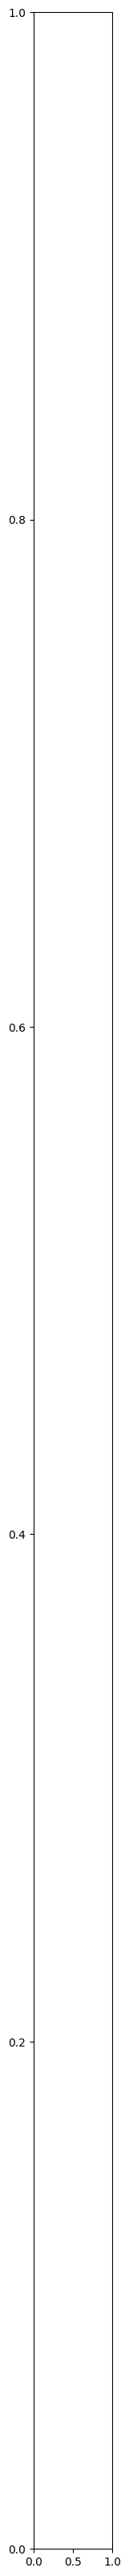

In [ ]:
# Flatten the 3D data to 2D for SHAP explainer
X_train_2d = X_train_seq.reshape((X_train_seq.shape[0], -1))
X_test_2d = X_test_seq.reshape((X_test_seq.shape[0], -1))

# Verify the flattened shapes
print(f'X_train_2d.shape: {X_train_2d.shape}')
print(f'X_test_2d.shape: {X_test_2d.shape}')

# Apply PCA to reduce dimensionality
n_components = 100  # Adjust n_components as needed
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_2d)
X_test_pca = pca.transform(X_test_2d)

# Verify the PCA shapes
print(f'X_train_pca.shape: {X_train_pca.shape}')
print(f'X_test_pca.shape: {X_test_pca.shape}')

# Define the prediction function
def predict_function(data):
    data_reconstructed = pca.inverse_transform(data)
    # The reshaping logic here should be: (num_samples, seq_length, num_features_per_time_step)
    num_features_per_time_step = data_reconstructed.shape[1] // seq_length
    data_reshaped = data_reconstructed.reshape((data.shape[0], seq_length, num_features_per_time_step))
    print(f'data_reshaped shape: {data_reshaped.shape}')  # Print to verify
    return best_model.predict(data_reshaped)

# Use KernelExplainer for SHAP values with reduced data
explainer = shap.KernelExplainer(predict_function, X_train_pca)

# Calculate SHAP values using the test data
shap_values = explainer.shap_values(X_test_pca, nsamples=100)

# Save intermediate results to avoid recomputation
np.save('shap_values.npy', shap_values)
np.save('X_test_pca.npy', X_test_pca)

# Ensure SHAP initialization
shap.initjs()

# Debug: Print shapes to verify consistency
print(f'shap_values shape: {np.array(shap_values).shape}')
print(f'X_test_pca shape: {X_test_pca.shape}')

# Plot SHAP values for feature importance
try:
    shap.summary_plot(
        shap_values,
        X_test_pca,
        feature_names=[f'PC{i+1}' for i in range(X_test_pca.shape[1])],
        max_display=50,
        plot_type='bar'
    )
except TypeError as e:
    print(f"Error during plotting: {e}")
    # Debugging info
    for i, shap_value in enumerate(shap_values):
        print(f'shap_values[{i}] shape: {shap_value.shape}')
    print(f'X_test_pca shape: {X_test_pca.shape}')

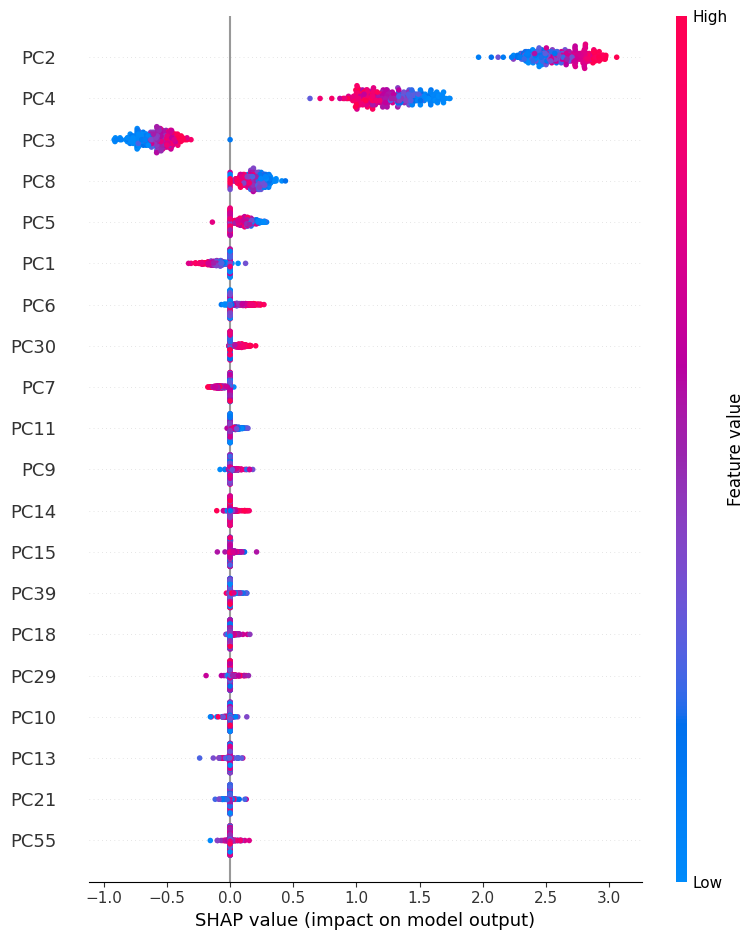

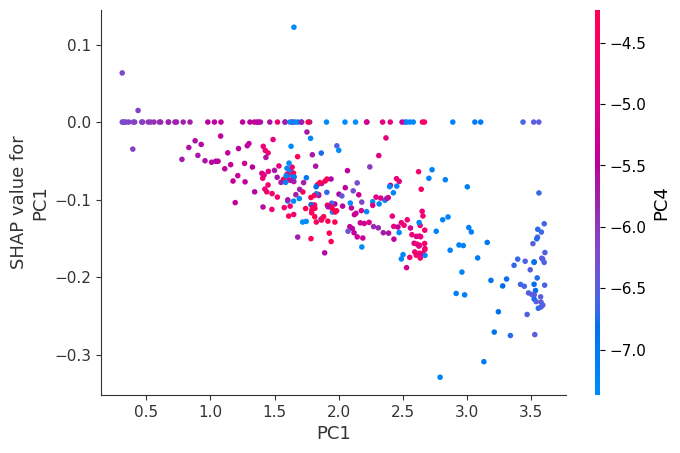

In [32]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Assuming shap_values is of shape (337, 100, 1)
# Reshape shap_values to (337, 100)
shap_values_reshaped = np.squeeze(shap_values)

# Plotting summary plot
shap.summary_plot(shap_values_reshaped, X_test_pca, feature_names=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])

# Optional: Plotting a dependence plot for the first principal component
shap.dependence_plot(0, shap_values_reshaped, X_test_pca, feature_names=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])


In [38]:
df_final2

,Rate (%),Volume ($Billions),LT COMPOSITE (>10 Yrs),TREASURY 20-Yr CMT,Yield Spread (4W - 52W),Yield Spread (13W - 52W),Yield Spread (26W - 52W),Yield Spread (10Y - 4W),Yield Spread (20Y - 4W),Yield Spread (10Y - 52W),...,CPI,SPX,NASDAQ,DJIA,SPOT EXCHANGE RATE - EURO AREA,"UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)","CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.","JAPAN -- SPOT EXCHANGE RATE, YEN/US$",PPI,Unemployment
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-02,1.77,361,2.90,2.85,0.41,0.31,0.16,1.23,1.18,0.82,...,250.546,2581.88,6870.12,23644.19,1.2288,1.4032,6.2785,105.99,115.500,4.0
2018-04-03,1.81,344,2.96,2.90,0.39,0.34,0.17,1.26,1.20,0.87,...,250.546,2614.45,6941.28,24033.36,1.2261,1.4068,6.2881,106.45,115.500,4.0
2018-04-04,1.70,348,2.97,2.91,0.39,0.36,0.17,1.29,1.23,0.90,...,250.546,2644.69,7042.11,24264.30,1.2292,1.4076,6.3045,106.56,115.500,4.0
2018-04-05,1.70,349,3.01,2.95,0.41,0.35,0.15,1.35,1.29,0.94,...,250.546,2662.84,7076.55,24505.22,1.2230,1.3991,6.3045,107.48,115.500,4.0
2018-04-06,1.70,352,2.94,2.89,0.39,0.33,0.16,1.27,1.22,0.88,...,250.546,2604.47,6915.11,23932.76,1.2274,1.4088,6.3045,107.03,115.500,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-14,5.30,785,4.42,4.46,-0.29,-0.33,-0.29,-0.93,-0.89,-0.64,...,314.069,5431.60,17688.88,38589.16,1.0699,1.2685,7.2557,157.28,144.402,4.1
2024-06-17,5.32,772,4.48,4.52,-0.23,-0.28,-0.26,-0.86,-0.82,-0.63,...,314.069,5473.23,17857.02,38778.10,1.0723,1.2689,7.2561,157.80,144.402,4.1
2024-06-18,5.32,763,4.43,4.47,-0.20,-0.29,-0.27,-0.86,-0.82,-0.66,...,314.069,5487.03,17862.23,38834.86,1.0739,1.2699,7.2543,157.81,144.402,4.1


In [40]:
# Generate appropriate column names
original_feature_names = df_final2.columns[1:]  # Excluding 'Rate (%)'
time_steps = seq_length
column_names = [f'{feature}_t{t}' for feature in original_feature_names for t in range(time_steps)]

# Create a DataFrame to hold the components and their corresponding feature names
components_df = pd.DataFrame(pca.components_, columns=column_names)

# Print the DataFrame to see the feature names corresponding to each principal component
print(components_df)

# Function to get the top 5 contributing features for each principal component
def get_top_features(components_df, pc_num, top_n=5):
    """
    Get the top N features for a given principal component.

    :param components_df: DataFrame of PCA components.
    :param pc_num: Principal component number (1-based index).
    :param top_n: Number of top features to retrieve.
    :return: Series of top N features and their corresponding weights.
    """
    pc_series = components_df.iloc[pc_num - 1]  # Convert to 0-based index
    top_features = pc_series.abs().sort_values(ascending=False).head(top_n)
    return top_features

# Example: Top 5 contributing features for the first principal component (PC1)
top_features_pc1 = get_top_features(components_df, 1)
print("Top 5 features for PC1:")
print(top_features_pc1)

# Example: Top 5 contributing features for the second principal component (PC2)
top_features_pc2 = get_top_features(components_df, 2)
print("Top 5 features for PC2:")
print(top_features_pc2)

    Volume ($Billions)_t0  Volume ($Billions)_t1  Volume ($Billions)_t2  \
0               -0.039809               0.008259               0.011758   
1                0.018562               0.054365               0.053051   
2               -0.042439               0.053937               0.052821   
3               -0.003877              -0.041998              -0.041475   
4                0.065704              -0.054193              -0.055037   
..                    ...                    ...                    ...   
95              -0.102620              -0.034693              -0.038280   
96               0.020414               0.031672               0.017840   
97               0.081311              -0.052344              -0.043386   
98               0.077179               0.011212               0.015761   
99               0.037013               0.018029               0.017240   

    Volume ($Billions)_t3  Volume ($Billions)_t4  Volume ($Billions)_t5  \
0                0.03065

# Account for Seasonality

In [ ]:
data = df_final2.copy()

In [ ]:
# Create seasonal features

def create_lagged_features(df, lag=1):
    df_lagged = df.copy()
    for col in df.columns:
        for i in range(1, lag + 1):
            df_lagged[f'{col}_lag_{i}'] = df[col].shift(i)
    return df_lagged

# Create differenced features
def create_differenced_features(df, lag=1):
    df_diff = df.copy()
    for col in df.columns:
        df_diff[f'{col}_diff_{lag}'] = df[col].diff(lag)
    return df_diff

# Apply lag and differencing
lag = 12  # to align with the ARIMA seasonal cycle
data_lagged = create_lagged_features(data, lag=lag)
data_differenced = create_differenced_features(data_lagged, lag=lag)

# Drop rows with NaN values created by lagging/differencing
data_prepared = data_differenced.dropna()

# Ensure the target variable is not included in the lagged/differenced features
target_variable = 'Rate (%)'
feature_columns = [col for col in data_prepared.columns if col != target_variable]

# Prepare the final dataset
X = data_prepared[feature_columns].values
y = data_prepared[target_variable].values


<ipython-input-39-df652e952f5b>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lagged[f'{col}_lag_{i}'] = df[col].shift(i)
<ipython-input-39-df652e952f5b>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lagged[f'{col}_lag_{i}'] = df[col].shift(i)
<ipython-input-39-df652e952f5b>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fra

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - loss: 3.6571 - val_loss: 2.2244
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 1.8104 - val_loss: 1.1142
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.9297 - val_loss: 0.6497
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.5378 - val_loss: 0.4397
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.3456 - val_loss: 0.3021
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2351 - val_loss: 0.2257
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1674 - val_loss: 0.1748
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1246 - val_loss: 0.1471
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0907 - val_loss: 0.1293
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0685 - val_loss: 0.0946
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0524 - val_loss: 0.1185
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.

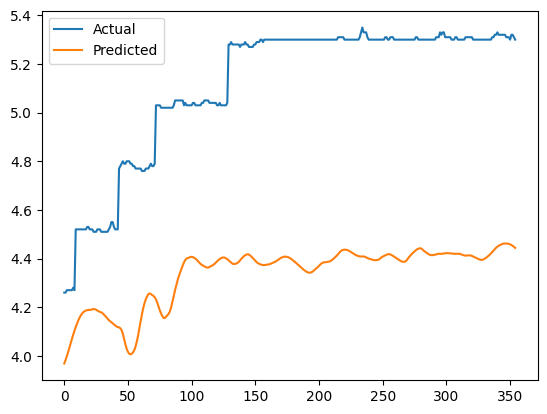

In [ ]:
# Split into training and test sets using boolean indexing with date strings
train_data = data_prepared.loc[:'2022-12-31']
test_data = data_prepared.loc['2023-01-01':]

# Separate features and target variable for training and testing sets
X_train = train_data[feature_columns].values
y_train = train_data[target_variable].values
X_test = test_data[feature_columns].values
y_test = test_data[target_variable].values

# Scaling values
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i + seq_length])
        y_seq.append(y[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 12  # Example: using past 12 months to predict the next month
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_length)

# Best parameters from Optuna
best_params = {
    'n_lstm_units': 50,
    'l2_regularization': 0.01,
    'dropout_rate': 0.2,
    'learning_rate': 0.001,
    'batch_size': 32
}

# Build the best model using the best hyperparameters
best_model = Sequential()
best_model.add(LSTM(best_params['n_lstm_units'], return_sequences=True, input_shape=(seq_length, X_train_seq.shape[2]), kernel_regularizer=l2(best_params['l2_regularization'])))
best_model.add(Dropout(best_params['dropout_rate']))
best_model.add(LSTM(best_params['n_lstm_units'], return_sequences=False, kernel_regularizer=l2(best_params['l2_regularization'])))
best_model.add(Dropout(best_params['dropout_rate']))
best_model.add(Dense(25, kernel_regularizer=l2(best_params['l2_regularization'])))
best_model.add(Dense(1))

# Compile the best model
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']), loss='mean_squared_error')

# Train the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
best_model.fit(X_train_seq, y_train_seq, batch_size=best_params['batch_size'], epochs=50, validation_data=(X_test_seq, y_test_seq), callbacks=[early_stopping])

# Predict using the best model
y_pred = best_model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred)
y_test_seq = scaler_y.inverse_transform(y_test_seq)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
mae = mean_absolute_error(y_test_seq, y_pred)
mse = mean_squared_error(y_test_seq, y_pred)
r2 = r2_score(y_test_seq, y_pred)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R-squared: {r2}')

# Plot the results
plt.plot(y_test_seq, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()
